# Homework 2: **Bayesian** *regression* and *classification*, ***Gaussian Processes*** (part 1)

Probabilistic Machine Learning -- Spring 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/emaballarin/probml-units/blob/main/homework-2023/02_bayesian_reg_class_gps_HW.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

### Exercise 1 (theory: *Bayesian conjugate modelling*)

Consider the Gamma distribution $\text{Gamma}(\alpha, \beta)$ with p.d.f. $\frac{\beta^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\beta x}$, and the Poisson distribution $\text{Poisson}(\lambda)$ with p.m.f. $\frac{\lambda^k e^{-\lambda}}{k!}.$

Given the model
$$
    \begin{align*}
    \lambda &\sim \text{Gamma}(\alpha, \beta)\\
    x &\sim \text{Poisson}(\lambda)
    \end{align*}
$$
prove that the Gamma distribution is a conjugate prior for the Poisson likelihood (for the given model).


#### Solution:
- $\text{Gamma}(\alpha, \beta)$ prior for $\lambda$:
$$ \lambda \sim  \text{Gamma}(\alpha, \beta) \Longrightarrow p(\lambda) = \frac{\beta^{\alpha}}{\Gamma (\alpha)} \lambda^{\alpha-1} e^{-\beta \lambda} \propto  \lambda^{\alpha-1} e^{-\beta \lambda}  $$

- i.i.d data:
$$ x_i \sim P(\lambda) \Longrightarrow p(x_i | \lambda) = \frac{\lambda^{x_i}e^{-\lambda}}{x_i !} $$

- Poisson likelihood:
$$ p( \mathbf{x} | \lambda) = p(x_1, \dots, x_N | \lambda) = \Pi_{i=1}^{N} p(x_i | \lambda) = \frac{\lambda^{\sum_{i} x_i} e^{-N \lambda}}{\Pi_{i} x_i !} \propto \lambda^{\sum_{i} x_i} e^{-N \lambda} $$

Using Bayes theorem disregarding the normalization constant, we have: $ p( \lambda | \mathbf{x}) \propto p(\mathbf{x} | \lambda ) p(\lambda)$, hence:
$$  p( \lambda | \mathbf{x}) \propto  \lambda^{\sum_{i} x_i} e^{-N \lambda}  \lambda^{\alpha-1} e^{-\beta \lambda} = \lambda^{\sum_{i} x_i + \alpha -1 }e^{-\lambda(N + \beta)} \sim Gamma(\sum_{i} x_i + \alpha, N + \beta)$$
which ends the proof.

### Exercise 2 (practicum: *`sklearn`, Naive Bayes*)

The *Wine* dataset is a classic *toy dataset* for classification tasks. It contains 178 samples of 3 different types of wine (encoded with a sequantial integer), with 13 continuous numeric features each. The goal is to (learn to) predict the type of an unknown wine (of any of those 3 types), given its specific features.

It can be easily imported from `sklearn` as:

```python
from sklearn.datasets import load_wine
... = load_wine()
```

Trying to use the `sklearn` interface as much as possible (no not *re-invent the wheel*!):

1. Split the dataset into a training and a test set (*hint:* use the `train_test_split` function), with the test split approximately $1/3^\text{rd}$ of the available data. Ensure that both sets are adequately representative of the problem at hand!

2. Fit a `LogisticRegression` model on the *training* split, and try to predict the labels from (just) the numeric features of the *test* split (*note:* we are not dealing with a *Bayesian* classifier yet; that will require - apart from theoretical knowledge, which you should already have! - sufficient experience with a Bayesian statistical modelling library, *e.g.* [Pyro](https://pyro.ai/), which will be introduced to you soon!)

3. Evaluate the performance of the model on the *test* split.

4. Fit a `GaussianNB` (*Naive Bayes classifier*) model on the *training* split, and try to predict the labels from (just) the numeric features of the *test* split. Evaluate the performance of the model on the *test* split.

5. Compare the performance of the two models according to a suitable metric and briefly comment.

#### Solution

1. Load the dataset and split it into train and test sets.

In [3]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
X, y = load_wine(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0, shuffle= True)

2. Fit a logistic regression model on the training data

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

logistic_regression = LogisticRegression(penalty='l2', random_state=0, max_iter=10000)
logistic_regression.fit(X_train, y_train)
y_predicted = logistic_regression.predict(X_test)

3. Evaluate the performances on the test data: \
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn-metrics-balanced-accuracy-score \
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn-metrics-accuracy-score

accuracy: 0.9833333333333333
balanced accuracy: 0.9861111111111112


<AxesSubplot: >

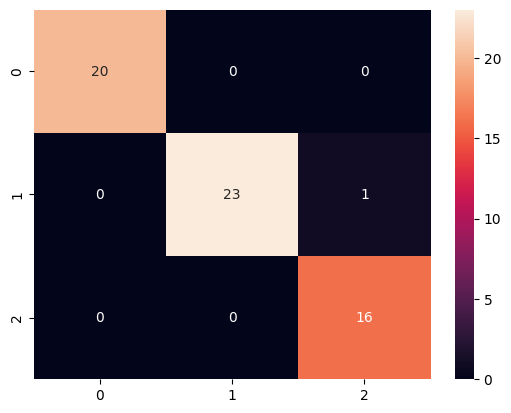

In [7]:
import seaborn as sns
print('accuracy:', accuracy_score(y_test, y_predicted))
print('balanced accuracy:', balanced_accuracy_score(y_test, y_predicted))
sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True)

4. Fit a naive-bayes classifier on training data and evaluate the model.

In [11]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
y_predicted = naive_bayes.predict(X_test)

accuracy: 0.95
balanced accuracy: 0.9583333333333334


<AxesSubplot: >

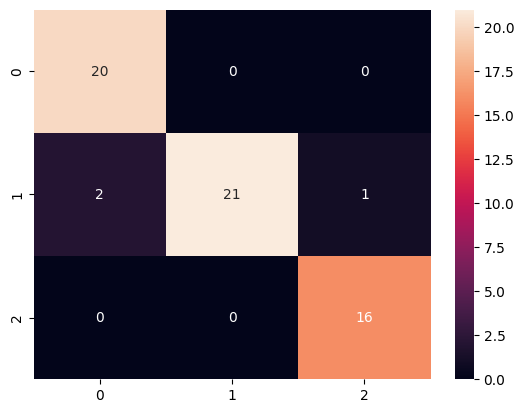

In [12]:
import seaborn as sns
print('accuracy:', accuracy_score(y_test, y_predicted))
print('balanced accuracy:', balanced_accuracy_score(y_test, y_predicted))
sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True)

5. It seems that both the logistic regression and the naive-bayes classifier perform well, according to both the score used. \
The fact that naive-bayes performs well means that it is reasonable to assume the independence of the features.

### Exercise 3 (practicum: *`sklearn`, Gaussian Process regression fitting*)

The *Mauna Loa Carbon Dioxide* dataset is another *toy* dataset, this time for **regression tasks** (specifically *time series* regression and prediction). It contains the raw recordings of atmospheric CO$_2$ concentration (in parts per million) at the Mauna Loa Observatory in Hawaii, in some days between 1958 and 2001. The goal is to (learn to) predict the CO$_2$ concentration at a given time, given the previous measurements.

By using some clever `sklearn` utilities, it can be easily imported as:

```python
from sklearn.datasets import fetch_openml
... = fetch_openml(data_id=41187, as_frame=True, parser="pandas")
```

On the resulting dataset, perform the following preprocessing steps (in `pandas`):

1. Drop from the dataset all the columns with data other than time information (if you want to convert time information to proper dates, you can use the `pandas.to_datetime` function; but that;s up to you!) and the actual carbon dioxide concentration (`co2`).

2. Compute monthly averages of the `co2` column and remove from the dataframe all resulting rows (*i.e.* months with no measurements al all).

#### Part 1
On the resulting dataset, perform the following preprocessing steps (in `pandas`):

1. Drop from the dataset all the columns with data other than time information (if you want to convert time information to proper dates, you can use the `pandas.to_datetime` function; but that;s up to you!) and the actual carbon dioxide concentration (`co2`).

2. Compute monthly averages of the `co2` column and remove from the dataframe all resulting rows (*i.e.* months with no measurements al all).

Load the data

In [7]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml(data_id=41187, as_frame=True, parser='pandas', return_X_y=True)

In [8]:
df = pd.concat([X, y], axis=1)
df.drop(['weight', 'flag', 'station'], axis=1, inplace= True)
print(df)

      year  month  day    co2
0     1958      3   29  316.1
1     1958      4    5  317.3
2     1958      4   12  317.6
3     1958      4   19  317.5
4     1958      4   26  316.4
...    ...    ...  ...    ...
2220  2001     12    1  370.3
2221  2001     12    8  370.8
2222  2001     12   15  371.2
2223  2001     12   22  371.3
2224  2001     12   29  371.5

[2225 rows x 4 columns]


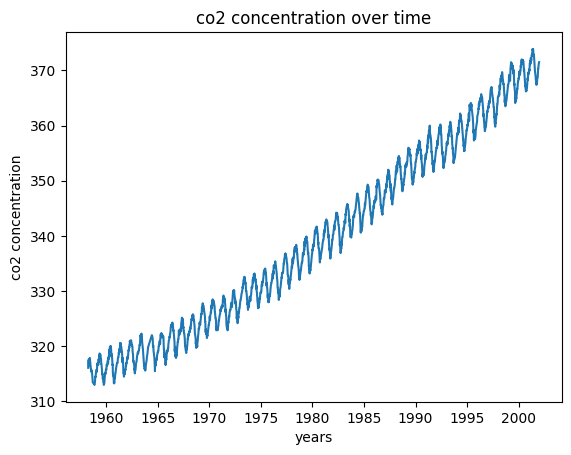

In [9]:
from matplotlib import pyplot as plt
df['date'] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day)) 

plt.plot(df['date'], df['co2'])
plt.title('co2 concentration over time')
plt.xlabel('years')
plt.ylabel('co2 concentration')
plt.show()

df_final = pd.concat([df['date'], df['co2']], axis=1)

Group by month and average:

In [10]:
monthly_mean = df_final.groupby(pd.PeriodIndex(df_final['date'], freq="M"))['co2'].mean()
monthly_mean

date
1958-03    316.100000
1958-04    317.200000
1958-05    317.433333
1958-07    315.625000
1958-08    314.950000
              ...    
2001-08    369.425000
2001-09    367.880000
2001-10    368.050000
2001-11    369.375000
2001-12    371.020000
Freq: M, Name: co2, Length: 521, dtype: float64

#### Part 2

Exploiting the contents of `sklearn.gaussian_process.kernels`, design an adequate kernel for the (predictive) regression task at hand, and fit a `GaussianProcessRegressor` model on a *training* split (which you need to define from original data, approximately 0.85 of the whole dataset), and try to predict the labels from (just) the numeric features of the *test* split. Evaluate the performance of the model on the remaining *test* split.

Notice that the task has been already solved (many!) times before (and such solutions may be available online!). The point of the exercise is to gain some experience with the `sklearn` interface for Gaussian Processes regression, and to get a feel for the kind of effects modelled by different choices of kernel (not to get perfect results!).

If you want to try (and show!) different possible solutions, feel free to do it. You may discover some potentially interesting phenomena!

Preprocessing 

Inspired by: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#build-the-dataset

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

co2 = fetch_openml(data_id=41187, as_frame=True, parser="pandas")

In [5]:
co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")

Now let's "play" with the dataset: \
first train a GP regressor on shuffled data, then train a GP regressor on ordered data to see the difference (and to highlight the fact that we are dealing with a time series, which in this case is a core point of the our problem)

##### GP regressor on shuffled data

Split the dataset and plot time vs co2

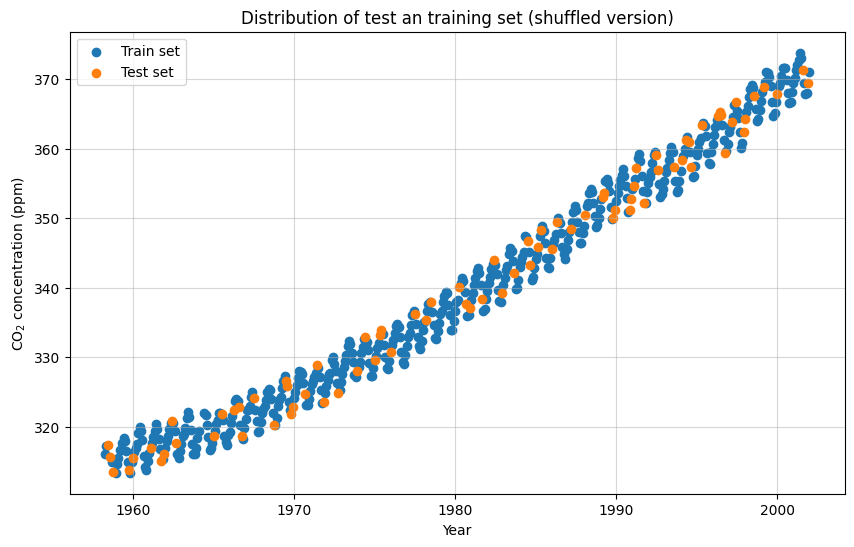

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    co2_data.index, co2_data.co2, train_size=.85, shuffle=True)

X_train = (X_train.year + X_train.month / 12).to_numpy().reshape(-1, 1)
X_test = (X_test.year + X_test.month / 12).to_numpy().reshape(-1, 1)

plt.figure(figsize=(10, 6))

plt.title("Distribution of test an training set (shuffled version)")

plt.scatter(X_train, y_train, label='Train set', alpha= 1)
plt.scatter(X_test, y_test, label='Test set', alpha=1)

plt.legend()

plt.xlabel("Year")
plt.ylabel("CO$_2$ concentration (ppm)")

plt.grid(alpha=.5)

plt.show()

In this first case (shuffled data), we take the designed kernel we can find at the following link: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#design-the-proper-kernel

In [11]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, RationalQuadratic

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
kernel =  long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel


gp = GaussianProcessRegressor(kernel=kernel, normalize_y= True).fit(X_train, y_train)

y_pred, std_y_pred = gp.predict(X_test, return_std=True)
print(' train score: ',gp.score(X_train, y_train))

 train score:  0.9999260903938634


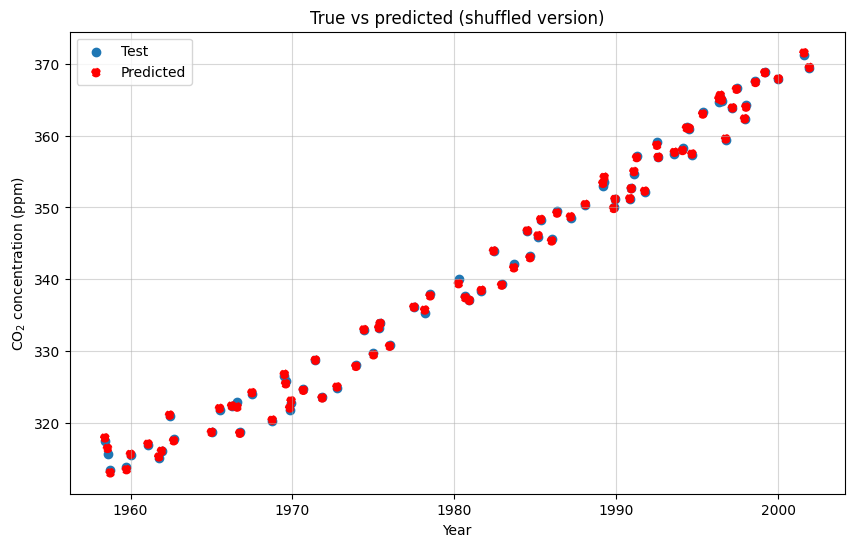

test score: 0.9997734885854008


In [12]:
plt.figure(figsize=(10, 6))

plt.title("True vs predicted (shuffled version)")

plt.scatter(X_test, y_test, label='Test', color='tab:blue')
plt.scatter(X_test, y_pred, label='Predicted', linestyle='dashed', color = 'red')


plt.legend()

plt.xlabel("Year")
plt.ylabel("CO$_2$ concentration (ppm)")

plt.grid(alpha=.5)

plt.show()

print('test score:',gp.score(X_test, y_test))

Plot version with confidence

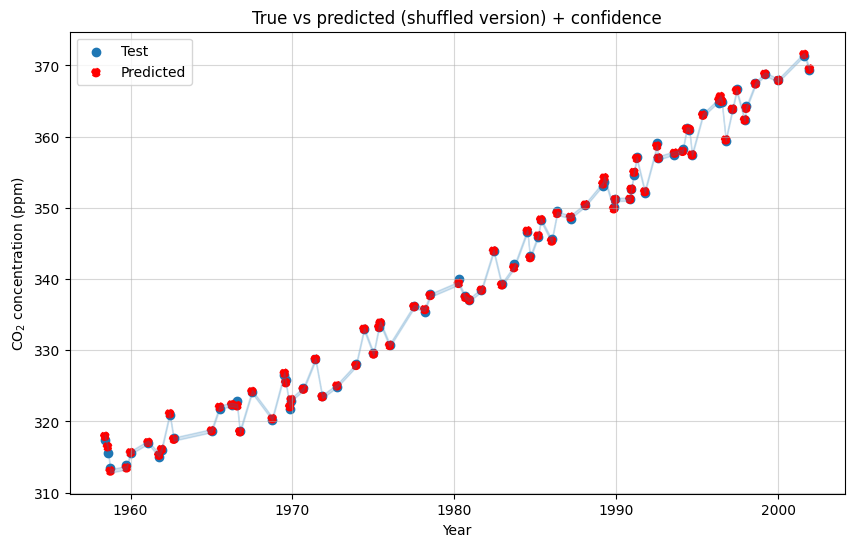

0.9997734885854008

In [13]:
plt.figure(figsize=(10, 6))

plt.title("True vs predicted (shuffled version) + confidence")

# little code to plot have the confidence in the case of shuffled data, which is not trivial
X_test_r = X_test.ravel()
y_pred_arr = y_pred
aind = np.argsort(X_test_r)
x_prime=X_test_r[aind]
y_prime=y_pred[aind]

#plt.scatter(X_train, y_train, label='Train set')
plt.scatter(X_test, y_test, label='Test', color='tab:blue')
plt.scatter(X_test, y_pred, label='Predicted', linestyle='dashed', color = 'red')

# comment the following if don't want the confidence
plt.fill_between(
    x_prime,
    y_prime - std_y_pred,
    y_prime + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)

plt.legend()

plt.xlabel("Year")
plt.ylabel("CO$_2$ concentration (ppm)")

plt.grid(alpha=.5)

plt.show()

gp.score(X_test, y_test)

##### GP regressor on ordered data

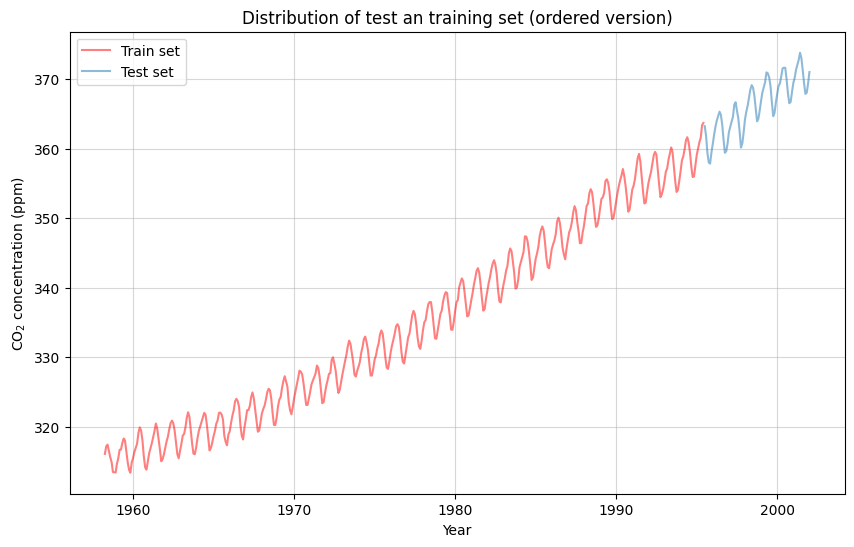

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    co2_data.index, co2_data.co2, train_size=.85, shuffle=False)

X_train = (X_train.year + X_train.month / 12).to_numpy().reshape(-1, 1)
X_test = (X_test.year + X_test.month / 12).to_numpy().reshape(-1, 1)

plt.figure(figsize=(10, 6))

plt.title("Distribution of test an training set (ordered version)")

plt.plot(X_train, y_train, label='Train set', alpha= .5, color = 'red')
plt.plot(X_test, y_test, label='Test set', alpha=.5)

plt.legend()

plt.xlabel("Year")
plt.ylabel("CO$_2$ concentration (ppm)")

plt.grid(alpha=.5)

plt.show()

Use the designed before kernel and plot (training with normalization turned on)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


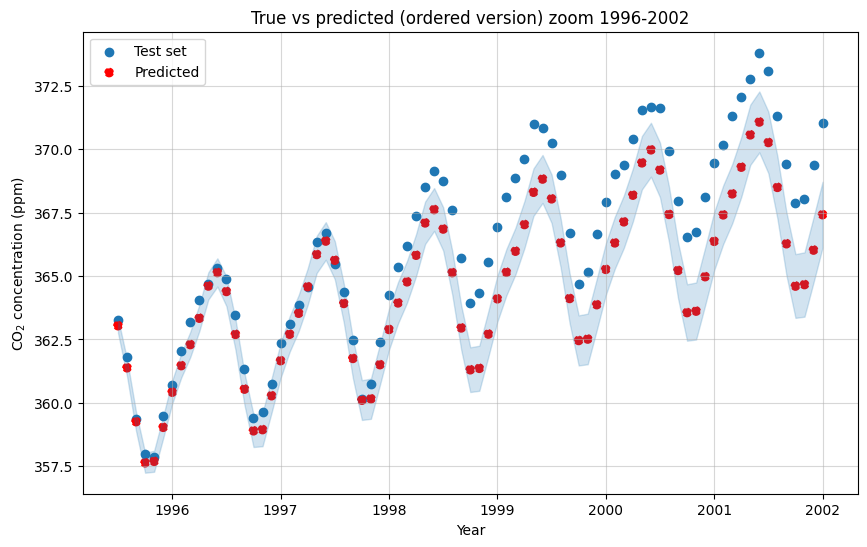

test score:  0.7154966769573976


In [16]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, RationalQuadratic

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
kernel = ( long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel)


gpr_model = GaussianProcessRegressor(
    kernel=kernel,
    random_state=0, normalize_y= True).fit(X_train, y_train )

y_pred, std_y_pred = gpr_model.predict(X_test, return_std=True)

plt.figure(figsize=(10, 6))

plt.title("True vs predicted (ordered version) zoom 1996-2002")

X_test_r = X_test.ravel()
aind = np.argsort(X_test_r)
x_prime=X_test_r[aind]
y_prime=y_pred[aind]

plt.scatter(X_test, y_test, label='Test set', color='tab:blue')
plt.scatter(X_test, y_pred, label='Predicted', linestyle='dashed', color = 'red')
plt.fill_between(
    x_prime,
    y_prime - std_y_pred,
    y_prime + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)

plt.legend()

plt.xlabel("Year")
plt.ylabel("CO$_2$ concentration (ppm)")

plt.grid(alpha=.5)

plt.show()

print('test score: ', gpr_model.score(X_test, y_test))

- Note that now, since train and test are ordered, the test set *is* exactly the most recent part of the dataset (1996-2002). Next we plot the above plot "embedded" in the whole time series, which is 1960-2002. 

- Note also that there is a **huge difference** in the score of the GP regressor on the shuffled version or not: now the score is much less than in the shuffled version. This might be consequence of the following fact: in the first case, since we train with shuffled data, the regressor in some sene "see" all the time series, so we get better score. In this case, we train only on the "first period" , so the regressor is missing some information about 1996-2002 period (it "doesn't see" data coming from 1996-2002), and we end up with a lower score.

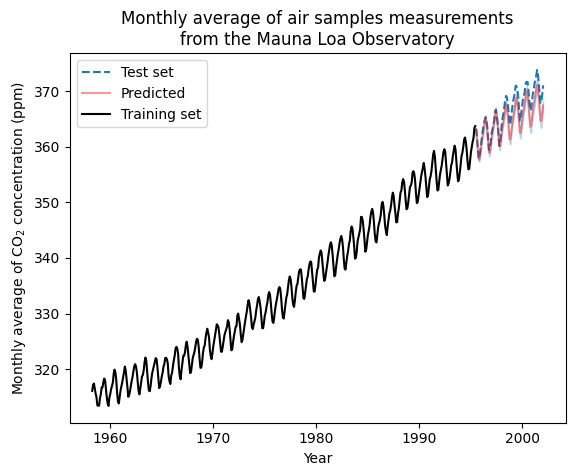

In [21]:
from matplotlib import pyplot as plt


plt.plot(X_test, y_test, color="tab:blue", linestyle="dashed", label="Test set")
plt.plot(X_test, y_pred, color="red", alpha=0.4, label="Predicted")
plt.plot(X_train, y_train, color="black", label = "Training set")
plt.fill_between(
    X_test.ravel(),
    y_pred - std_y_pred,
    y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
) 

Training with normalization turned off (score is not normalized)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


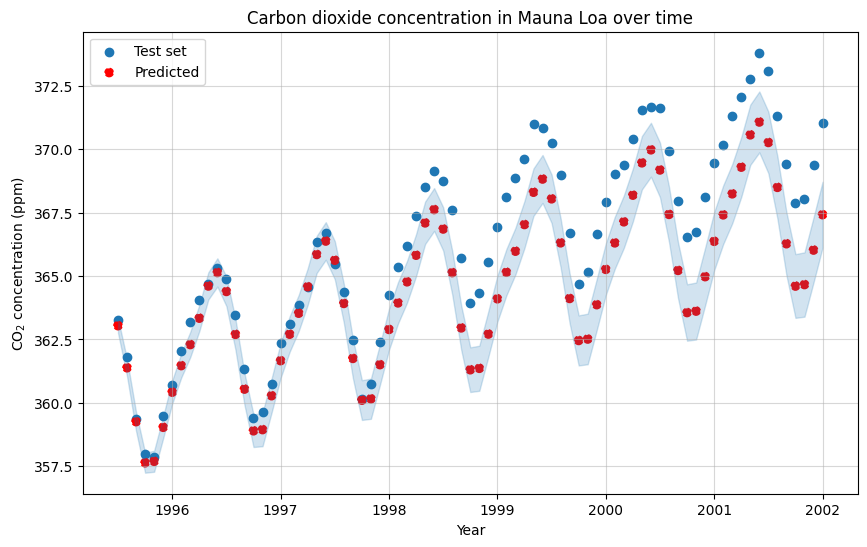

-7496.694133201444

In [22]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, RationalQuadratic

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
kernel = ( long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel)


gpr_model = GaussianProcessRegressor(
    kernel=kernel,
    random_state=0, normalize_y= False).fit(X_train, y_train - y_train.mean() )

y_pred, std_y_pred = gpr_model.predict(X_test, return_std=True)
y_pred += y_train.mean()

plt.figure(figsize=(10, 6))

plt.title("Carbon dioxide concentration in Mauna Loa over time")

X_test_r = X_test.ravel()
aind = np.argsort(X_test_r)
x_prime=X_test_r[aind]
y_prime=y_pred[aind]

#plt.scatter(X_train, y_train, label='Train set')
plt.scatter(X_test, y_test, label='Test set', color='tab:blue')
plt.scatter(X_test, y_pred, label='Predicted', linestyle='dashed', color = 'red')
plt.fill_between(
    x_prime,
    y_prime - std_y_pred,
    y_prime + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)

plt.legend()

plt.xlabel("Year")
plt.ylabel("CO$_2$ concentration (ppm)")

plt.grid(alpha=.5)

plt.show()

gpr_model.score(X_test, y_test)

Now let's try different kernels, and plot their prediction and confidence.

In [23]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared

# https://scikit-learn.org/stable/modules/gaussian_process.html#basic-kernels

kernel_RBF = RBF()
kernel_WhiteKernel = WhiteKernel()
kernel_ConstantKernel = ConstantKernel()
kernel_ExpSineSquared = ExpSineSquared(periodicity=12)
kernel_RBF_ExpSine = RBF() + ExpSineSquared(periodicity=12)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


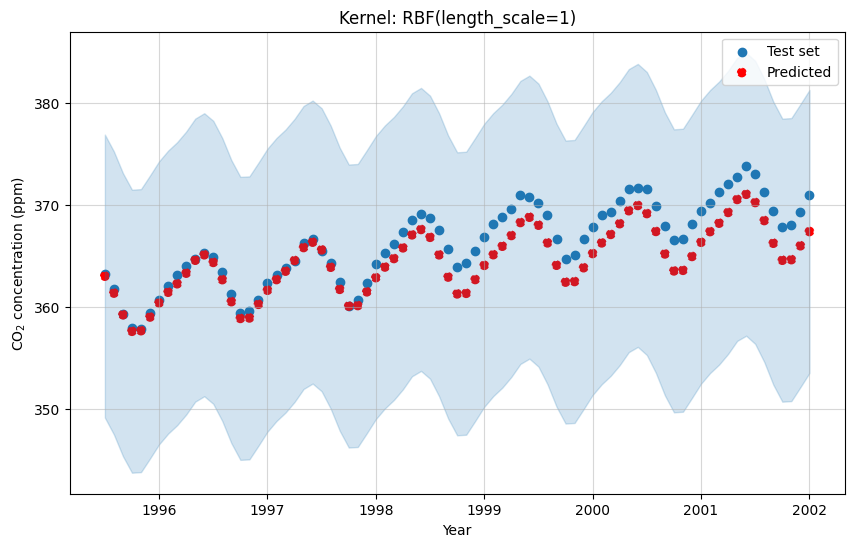

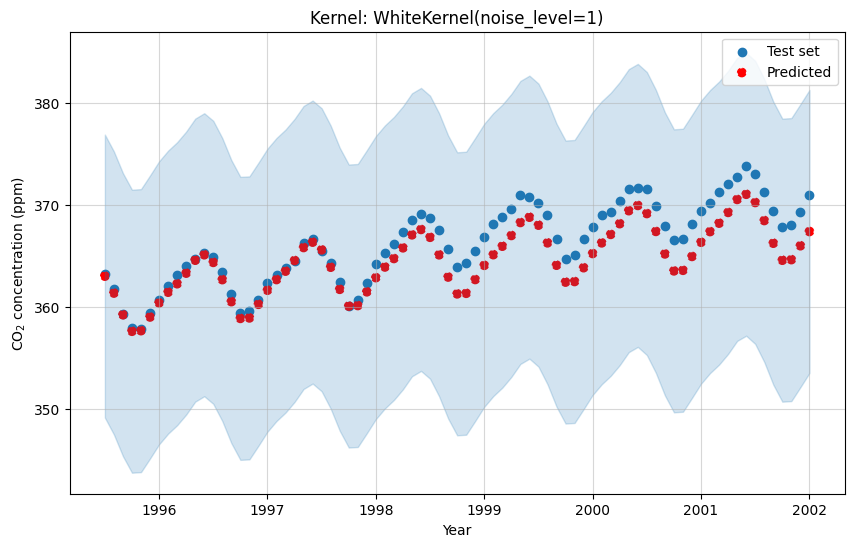

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:445: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


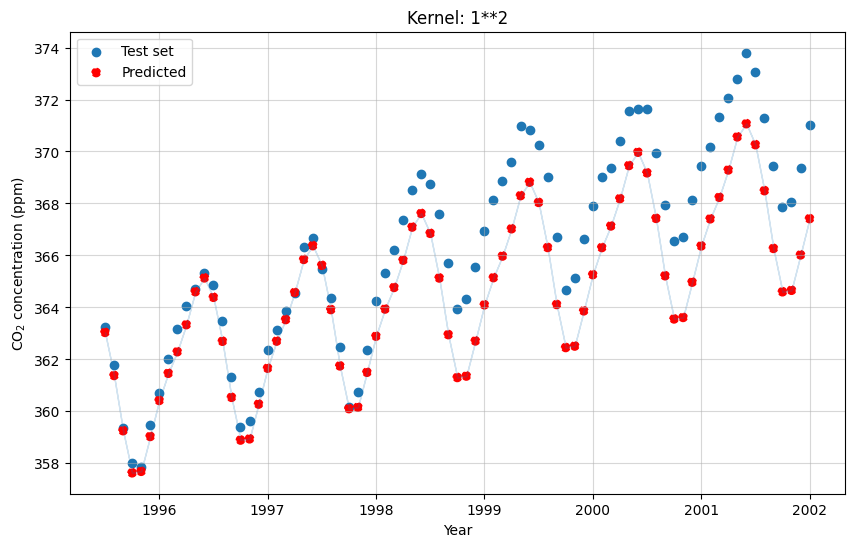

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


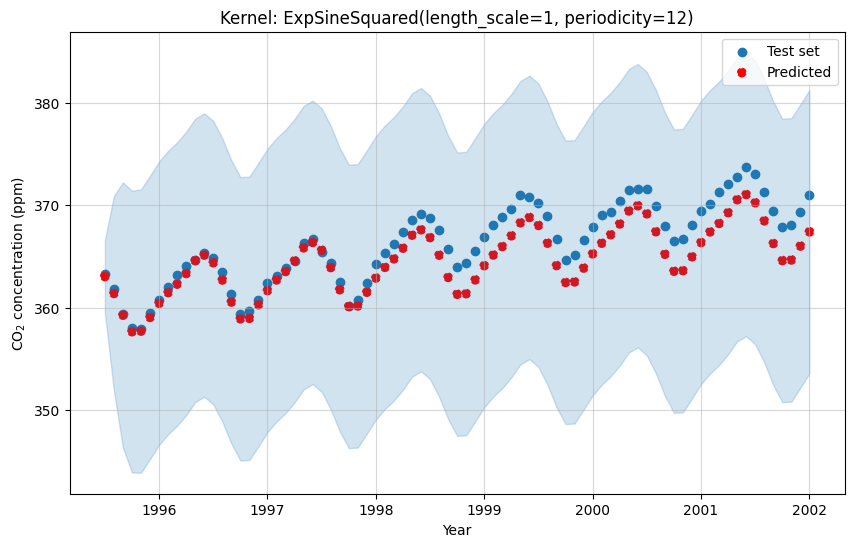

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better va

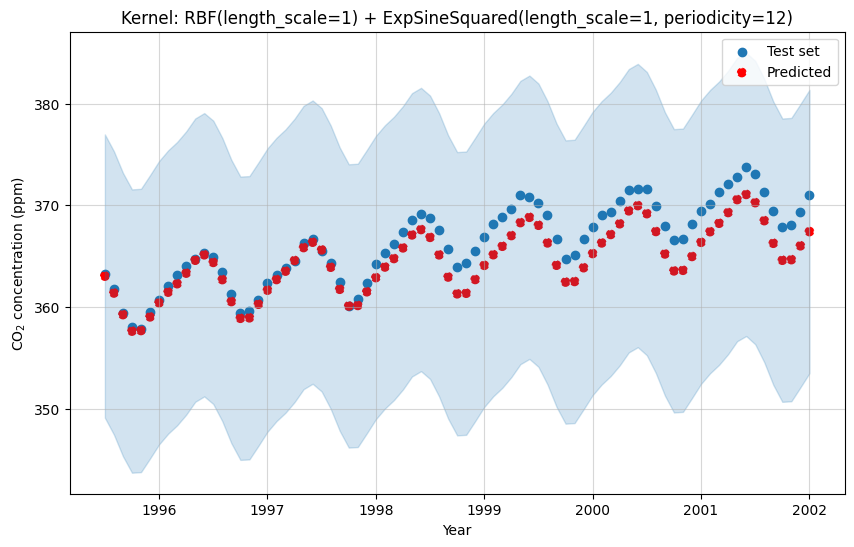

In [28]:
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np

kernels = [kernel_RBF, kernel_WhiteKernel, kernel_ConstantKernel, kernel_ExpSineSquared, kernel_RBF_ExpSine]
scores = []
for k in kernels:
    gp = GaussianProcessRegressor(kernel= k, normalize_y=True)
    gp.fit(X_train, y_train)
    scores.append(gp.score(X_test, y_test))

    # predict
    mean_y_pred, std_y_pred = gp.predict(X_test, return_std=True)
    #mean_y_pred =mean_y_pred 

    plt.figure(figsize=(10, 6))

    plt.title("Kernel: {}".format(k))

    X_test_r = X_test.ravel()
    aind = np.argsort(X_test_r)
    x_prime=X_test_r[aind]
    y_prime=y_pred[aind]

    #plt.scatter(X_train, y_train, label='Train set')
    plt.scatter(X_test, y_test, label='Test set', color='tab:blue')
    plt.scatter(X_test, y_pred, label='Predicted', linestyle='dashed', color = 'red')
    plt.fill_between(
        x_prime,
        y_prime - std_y_pred,
        y_prime + std_y_pred,
        color="tab:blue",
        alpha=0.2,
    )

    plt.legend()

    plt.xlabel("Year")
    plt.ylabel("CO$_2$ concentration (ppm)")

    plt.grid(alpha=.5)

    plt.show()



In [29]:
for i in range(len(scores)):
    print(kernels[i], 'test score: ', scores[i])

RBF(length_scale=1) test score:  -64.30090906810283
WhiteKernel(noise_level=1) test score:  -64.30090906810283
1**2 test score:  -111.20463332906766
ExpSineSquared(length_scale=1, periodicity=12) test score:  -63.037486658185884
RBF(length_scale=1) + ExpSineSquared(length_scale=1, periodicity=12) test score:  -64.30852910286214


#### **OPTIONAL:**  
Try to fit the model on the whole dataset and predict values of carbon dioxide concentration until today. Does the model capture the features of the time series well enough? \
For this task, we will use the following kernel.

In [33]:
kernel_RBF_ExpSine = RBF() + ExpSineSquared(periodicity=12)

In [37]:
X = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_data["co2"].to_numpy()

In [49]:
import datetime
import numpy as np
gaussian_process = GaussianProcessRegressor(kernel=kernel_RBF_ExpSine, normalize_y=False)
gaussian_process.fit(X, y - y.mean())
today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=2002, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y.mean()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better va

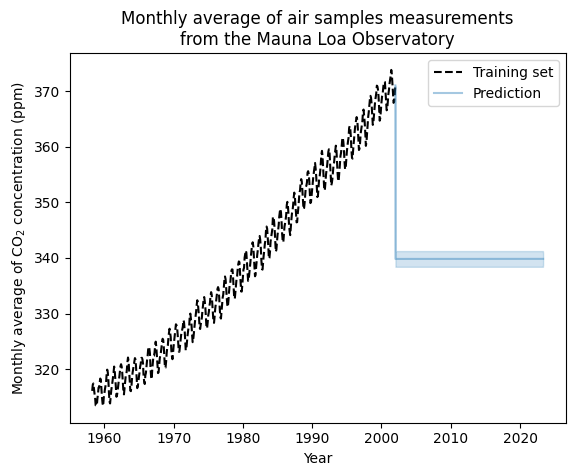

In [50]:
plt.plot(X, y, color="black", linestyle="dashed", label="Training set")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Prediction")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

Difference if we use the kernel designed in the article mentioned before

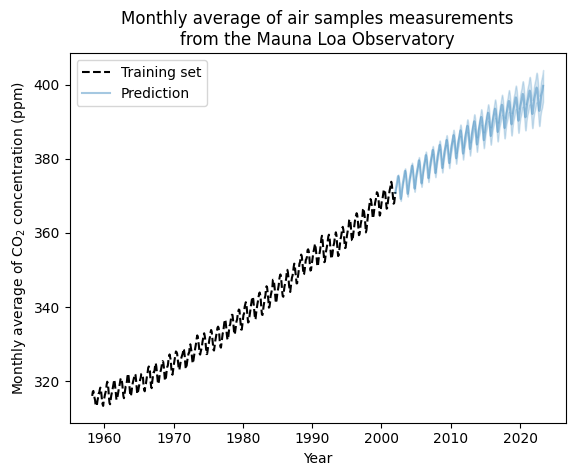

In [51]:
gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
gaussian_process.fit(X, y - y.mean())

mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y.mean()

plt.plot(X, y, color="black", linestyle="dashed", label="Training set")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Prediction")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

### Exercise 4 (practicum: `sklearn`, Gaussian Process classification fitting; potentially requiring theory *to-be-covered*)

Consider an instance of the *Circles* dataset, yet another *toy* dataset for classification featuring two concentric elliptical annuli. For the sake of simplicity, it has been already be generated and plotted for you:

In [53]:
import numpy as np
from sklearn.datasets import make_circles
from matplotlib import pyplot as plt

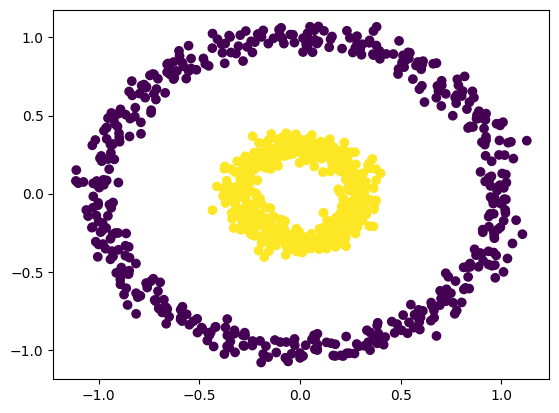

In [54]:
x, y = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
_ = plt.scatter(x[:, 0], x[:, 1], c=y)

`sklearn`'s `GaussianProcessClassifier` approximates the non-Gaussian posterior by a Gaussian approximated through Laplace's saddle-point approximation.

Define an RBF kernel (*hint*: there's a `sklearn.gaussian_process.kernels.RBF` function just for that!) with lenghtscale parameter $l = 1$ and fit a Gaussian Process classifier to the observed data $(x,y)$ from *Circles* right above.

In [56]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier

kernel = RBF(length_scale=1, length_scale_bounds='fixed') # 'fixed' used to don't do hyper-params tunung
sklearn_gp_classifier = GaussianProcessClassifier(kernel = kernel)
sklearn_gp_classifier = sklearn_gp_classifier.fit(x, y)

The functions that follow, evaluate and plot the posterior predictive mean function over a finite grid of points. Most importantly, the `plot_sklearn_predictions` function requires as arguments the learned GP classifier `sklearn_gp_classifier`, the observed points `x` and their labels `y`.

In [57]:
def meshgrid(x, n, eps=0.1):
    x0, x1 = np.meshgrid(
        np.linspace(x[:, 0].min() - eps, x[:, 0].max() + eps, n),
        np.linspace(x[:, 1].min() - eps, x[:, 1].max() + eps, n),
    )
    x_grid = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    return x0, x1, x_grid


def plot_sklearn_predictions(sklearn_gp_classifier, x, y):
    x0, x1, x_grid = meshgrid(x, 30)

    preds = sklearn_gp_classifier.predict_proba(x_grid)

    _ = plt.figure(figsize=(10, 6))
    _ = plt.contourf(x0, x1, preds[:, 0].reshape(x0.shape), 101, vmin=0, vmax=1)
    _ = plt.contourf(x0, x1, preds[:, 1].reshape(x0.shape), 101, vmin=0, vmax=1)

    _ = plt.title("Posterior Mean")
    _ = plt.xticks([])
    _ = plt.yticks([])
    _ = plt.colorbar()
    _ = plt.scatter(x[:, 0], x[:, 1], c=y)

Plot the posterior predictive mean function and the training data, and comment.

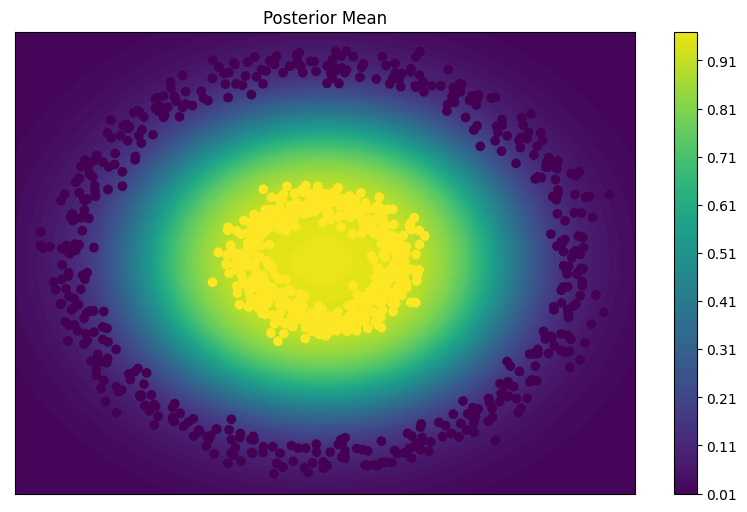

In [58]:
plot_sklearn_predictions(sklearn_gp_classifier, x, y)

The gaussian proccess seems to be a good separator for the data.
We have points whose coordinates are closer to training points inside class 1 to have much probability of belonging to class 1, and viceversa, as expected.

### Not-an-exercise 5 (*Kernels? Why bother?*)

The following *task* is completely optional and up to your personal curiosity (and also a result of *my own* curiosity 🙃). It will be in no way considered for evaluation-related purposes: it may lead to interesting discussions though (or exam projects? and beyond? who knows!).

If you have never had the occasion to, watch this [brief talk by Ali Rahimi](https://www.youtube.com/watch?v=ORHFOnaEzPc), given in occasion of the 2018 *NeurIPS Test of Time award* (awarded his co-authored 2007 paper with Ben Recht ["Random Features for Large-Scale Kernel Machines"](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf)).

If you have some comments about it, feel free to write or voice them!